<center>
<header>

<h4 style="text-align:right">16-04-2023</h4>
<h1 style="text-align:center">Reinforcement Learning - Final Project </br> <u><i>Giacopelli Nicolò & Girardin Oskar</i> </h1></u>
<h2> Traffic Control </h2>

</header>
</center>


In [ ]:
# !pip install gymnasium --quiet

import gymnasium as gym
import numpy as np
import os, sys
import time
import sys
import pygame
import random
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import ast
import json
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import plotly.express as px

import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("pastel"))


from collections import namedtuple, deque
from itertools import count

import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


from IPython import display

plt.ion()

# if connected to drive
#from google.colab import drive
#drive.mount('/content/drive')


import traffic_control_game
from traffic_control_game.envs.logic import Setup
import tiles3 as tc

This notebook aims at addressing the study done for the Traffic Control implementation, implemented as the final project of the Reinforcement Learning course at CentraleSupélec. The implementation of the environment, which constituted a large percentage of total work, is implemented in a separate folder. This notebook aims instead at addressing the study performed for the different agents we evaluated, that is for their performances in solving the environment. </br> The agents we implemented are $3$ different versions of a Q-learning agent. **1.** The first concerns an implementation from the dynamic programming perspective, **2.** the second with a semi-gradient function approximation with tiling, **3.** the third one with a Deep Q-Network structure.

### Useful functions

In [ ]:
def timer(start_time=None, string=None):
    '''
    Function to compute the time
    start_time : starting time generated calling this function without arguments the first time
    string: visualization purposes (task description)
    '''
    if not start_time:
        start_time=datetime.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.datetime.now()-start_time).total_seconds(),3600)
        tmin, tsec = divmod(temp_sec,60)
        pr = "for " + str(string) + " " if string else ""
        print("Execution time", pr, "is ", thour," h :", tmin,' m :', round(tsec,2), " s")

In [ ]:
"""
Function to load and store dictionaries safely by saving converting them
to json format. Used due to the long training times and the instability
of Collab
"""

def save_json(q, filename):
    with open(f'{filename}.json', 'w') as fp:
        to_json = str({k: list(v) for k, v in q.items()})
        json.dump(to_json, fp)
    

def load_json(filename):
    with open(f'{filename}.json') as json_file:
        data = ast.literal_eval(json.load(json_file))
    return data
    

### Environment initialization

In [ ]:
# Environment initialization (with rendering)

env_steps = 150
max_waiting_time = 25
ps_ns = np.random.uniform(low=0.025, high=0.035, size=1)
ps_ew = np.random.uniform(low=0.06, high=0.065, size=1)
ps = np.tile(np.concatenate((ps_ns, ps_ew)), 2)

env_info = {"ps": ps, "max_wait_time": max_waiting_time, "env_steps": env_steps, "n_states": 2}            
        
env = gym.make("traffic_control-v0", env_info=env_info, render_mode="human") 

print(f"Observations space: {env.observation_space}")
print(f"Action space: {env.action_space}")


Observations space: Dict('NS': Discrete(72), 'PA': Discrete(6), 'WE': Discrete(100), 'WT': Discrete(25))
Action space: Discrete(6)


## Q-learning agent based on Dynamic Programming

## Semi-Gradient Q-learning agent (with tilings)

In [ ]:

class TileCoder:
    ''' Class to facilitate tile coding representations of states passed as parameters '''
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, queue_ns, queue_we, wt, pa):
        global env, env_info
        
        # Range of minimum and maximum value for each of the 2 components of the observation vector
        ns_min, ns_max = float(env.observation_space["NS"].start), float(env.observation_space["NS"].start + env.observation_space["NS"].n-1)
        we_min, we_max = float(env.observation_space["WE"].start), float(env.observation_space["WE"].start + env.observation_space["WE"].n-1)
        wt_min, wt_max = 0, env_info["max_wait_time"]
        pa_min, pa_max = 0, env.action_space.n-1
        
        queue_ns_scaled = (queue_ns-ns_min)*(self.num_tiles / (ns_max-ns_min))
        queue_we_scaled = (queue_we-we_min)*(self.num_tiles / (we_max-we_min))
        wt_scaled = (wt-wt_min)*(self.num_tiles / (wt_max-wt_min))
        pa_scaled = (pa-pa_min)*(self.num_tiles / (pa_max-pa_min))

        tiles = tc.tiles(self.iht, self.num_tilings, [queue_ns_scaled, queue_we_scaled, wt_scaled, pa_scaled])
        
        return np.array(tiles)
        

In [ ]:

class QAgent():
    """
    Class for the Semi-Gradient Q-learning agent with tiling
    """
    def __init__(self):
        """ All values are set to None so they can be initialized in the agent_init method """
        self.num_tilings = None
        self.num_tiles = None
        self.iht_size = None
        self.initial_weights =None
        self.action_count = None
        
        self.eps_start = None
        self.eps_decay = None
        self.eps_end = None
        self.eps_runn = None
        
        self.discount = None
        self.num_actions = None
        self.step_size = None
        self.w =None
        self.tc = None
        self.previous_tiles, self.previous_action = None, None

    def info_init(self, info={}):
        """Setup for the agent, passed in a dictionary, called when the experiment first starts """
        self.num_tilings = info.get("num_tilings", 8)
        self.num_tiles = info.get("num_tiles", 8)
        self.iht_size = info.get("iht_size", 4096)
        self.initial_weights = info.get("initial_weights", 0.0)

        # epsilon
        self.eps_start = info.get("eps_start", 1.0)
        self.eps_decay = info.get("eps_decay", 2500)
        self.eps_end = info.get("eps_end", 1e-5)
        self.eps_runn = info.get("eps_start", 1.0)

        self.discount = info.get("discount", 1.0)
        self.num_actions = info.get("num_actions", 6)
        self.step_size = info.get("step_size", 0.5) / self.num_tilings

        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights

        self.tc = TileCoder(iht_size=self.iht_size, 
                            num_tilings=self.num_tilings, 
                            num_tiles=self.num_tiles)
        
        self.action_count = defaultdict(int)
        
    def decay(self, episode):
      """ Exponential epsilon decay """
      self.eps_runn = self.eps_end + (self.eps_start - self.eps_end)*np.exp(-1*episode/self.eps_decay)
      
    def get_freq_action(self):
      """ Method used to compute the ratios of selection for each action """
      tot_chosen = np.sum(list(self.action_count.values()))
      return [self.action_count.get(action, 0)/tot_chosen for action in range(self.num_actions)]

    def get_value(self, state):
      """ Function used to plot the estimates of state-action value """
      active_tiles = self.tc.get_tiles(queue_ns=state["NS"], queue_we=state["WE"], wt=state["WT"], pa=state["PA"]) 
      action, value = self.choose_action(active_tiles, greedy=True)
      return action, value

    def argmax(self, values):
      """ Randomly tie-breaker argmax """
      top = float("-inf")
      ties = []
      for i in range(len(values)):
          if values[i] > top:
              top = values[i]
              ties = []
          if values[i] == top:
              ties.append(i)
      return np.random.choice(ties)

    def play(self, env, fin_score = 4000, render_=False, print_info=False):
      ''' Method used outside of training to simulate a greedily played game'''
      state, info = env.reset()
      if print_info:
        print("The game has started...")
      while True:
          active_tiles = self.tc.get_tiles(queue_ns=state["NS"], queue_we=state["WE"], wt=state["WT"], pa=state["PA"]) 
          action, _ = self.choose_action(active_tiles, greedy=True)
          next_state, reward, done, _, info = env.step(action)

          if render_:
            # Render the game
            env.render()
          
          if (done) or (info["score"]>=fin_score): # If player is dead break
            to_vis = info["score"]
            if print_info:
              print(f"\nThe game is done! Final score: {to_vis: ,}\n")
            break
          else:
            state = next_state  
      env.close()
      return to_vis

    def choose_action(self, tiles, greedy=False):
      ''' Function to choose action according to epsilon-greedy strategy,
          based on current tile-based state representation  '''
      action_values = [np.sum(self.w[action][tiles]) for action in range(self.num_actions)] 
      if (np.random.random()<self.eps_runn) and (not greedy):
        chosen = np.random.choice(self.num_actions) 
      else:
        chosen = self.argmax(action_values) 
      self.action_count[chosen] += 1
      return chosen, action_values[chosen]

    def start(self, state):
      """ Take first move and store first action and tile-based representation of state """
      active_tiles = self.tc.get_tiles(queue_ns=state["NS"], queue_we=state["WE"], wt=state["WT"], pa=state["PA"]) 
      action, _ = self.choose_action(active_tiles, greedy=False)

      self.previous_tiles = np.copy(active_tiles)
      self.previous_action = action
      return action

    def update(self, reward, state):
      """ Update of Sarsa algorithm (on-policy method)
          The q-values of the previous state-action pair are updated
          based on the value of the action taken in successive state (passed as parameter) """

      if state:
        active_tiles = self.tc.get_tiles(queue_ns=state["NS"], queue_we=state["WE"], wt=state["WT"], pa=state["PA"]) 
        action, action_value = self.choose_action(active_tiles, greedy=False)
      
        all_action_values = [np.sum(self.w[action][active_tiles]) for action in range(self.num_actions)] 

      action_value = np.amax(all_action_values) if state!=False else 0
      update_target = reward + self.discount*action_value - np.sum(self.w[self.previous_action][self.previous_tiles])
      self.w[self.previous_action][self.previous_tiles] += self.step_size * update_target * np.ones((self.num_tilings,))

      if not state:
        return
      else:
        self.previous_tiles = np.copy(active_tiles)
        self.previous_action = action
        return action


In [ ]:

def loop_episodes(agent, agent_info, env, print_=False):
    """ Function for the main loop of the Semi-Gradient Q-learning agent with tiles """

    num_episodes = agent_info.get("num_episodes", 5000)  # agent initialization with info dictionary
    agent.info_init(agent_info)

    store, best_score = defaultdict(list), 0
    
    # Loop over episodes
    for i_episode in range(1, num_episodes+1):
        
      state, info = env.reset()   # first state

      action = agent.start(state)  # first action
      runn_score = 0
      runn_rewards = []

      while True:
        next_state, reward, done, _, info = env.step(action)
        runn_rewards.append(reward)

        # we break out also when score is greater than a maximum cap
        if (done) or (info["score"]>30000):          
          
          agent.update(reward, False)  # update of one-to-last state

          # update
          best_score = max(best_score, info["score"])
          store["total_max_scores"].append(best_score)
          store["total_scores"].append(info["score"])
          store["epsilon"].append(agent.eps_runn)
          store["avg_reward_episode"].append(np.mean(runn_rewards))
          break
        
        else:
          action = agent.update(reward, next_state)
          continue
      
      agent.decay(i_episode)
      
      # info
      action_freq = agent.get_freq_action()
      store["action_freq"].append(action_freq)
      
      if print_:
        if i_episode % 100 == 0:
          print("\rEpisode {}/{}, Epsilon {: .4f}, Avg Scores: {: .4f}, Max Score: {}, Action frequencies: {}.".format(i_episode, num_episodes,
                                                                         store["epsilon"][-1], 
                                                                         np.mean(store["total_scores"]), 
                                                                         store["total_max_scores"][-1],
                                                                         ", ".join([str(round(x, 5)) for x in action_freq])))

    return agent, store


In [ ]:


# Environment initialization (no render for training)


env_steps = 150
max_waiting_time = 25
ps_ns = np.random.uniform(low=0.025, high=0.035, size=1)
ps_ew = np.random.uniform(low=0.06, high=0.065, size=1)
ps = np.tile(np.concatenate((ps_ns, ps_ew)), 2)

env_info = {"ps": ps, "max_wait_time": max_waiting_time, "env_steps": env_steps, "n_states": 2}        
        
env = gym.make("traffic_control-v0", env_info=env_info) 



In [ ]:

# Learning process

agent = QAgent()
num_episodes = 2200

agent_info = {"num_tilings": 12,
        "num_tiles": 12,
        "iht_size": 8000,
        "num_episodes": num_episodes,
        "num_actions": env.action_space.n,
        "step_size": 0.5,  # divided by number of tilings
        "discount": 1.0,
        "eps_start": 1.0,
        "eps_decay": 650,  # with exponential decay
        "eps_end": 1e-6} 


start = timer()

agent_Q, store_Q = loop_episodes(agent, agent_info, env, print_=True)

# Training

print("")
timer(start, "Training Q agent")

Episode 100/2200, Epsilon  0.8587, Avg Scores:  2.5800, Max Score: 47, Action frequencies: 0.19527, 0.16568, 0.17357, 0.15582, 0.16174, 0.14793.
Episode 200/2200, Epsilon  0.7363, Avg Scores:  4.3200, Max Score: 87, Action frequencies: 0.18779, 0.17371, 0.1784, 0.14272, 0.17559, 0.14178.
Episode 300/2200, Epsilon  0.6313, Avg Scores:  4.7500, Max Score: 87, Action frequencies: 0.18916, 0.16882, 0.18854, 0.14295, 0.16636, 0.14418.
Episode 400/2200, Epsilon  0.5413, Avg Scores:  6.5300, Max Score: 197, Action frequencies: 0.18444, 0.17822, 0.20889, 0.14, 0.15333, 0.13511.
Episode 500/2200, Epsilon  0.4641, Avg Scores:  8.4240, Max Score: 197, Action frequencies: 0.19307, 0.18457, 0.21312, 0.13868, 0.14412, 0.12644.
Episode 600/2200, Epsilon  0.3979, Avg Scores:  10.1850, Max Score: 250, Action frequencies: 0.1905, 0.19323, 0.22462, 0.13564, 0.13837, 0.11763.
Episode 700/2200, Epsilon  0.3412, Avg Scores:  11.4971, Max Score: 250, Action frequencies: 0.1872, 0.19726, 0.2336, 0.13463, 0.13

In [ ]:

# Save and store dictionary containing all results for graphs

save_json(store_Q, "store_q_2500")   

with open('q_table_tiles_2500.npy', 'wb') as f:  
  np.save(f, agent_Q.w)    

store_Q = load_json("store_q_2500")


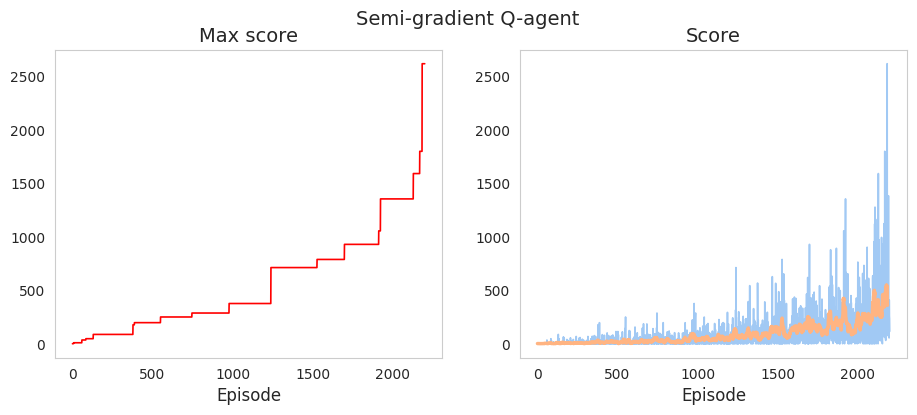

In [ ]:

# Plot maximum score and evolution scores (with running mean)

fig, axs = plt.subplots(1, 2, figsize=(11, 4))

titles = ["Max score", "Score"]
colors = ["r", "b"]

total_scores, total_max_scores = store_Q["total_max_scores"], store_Q["total_scores"]

for idx, (ax, score, title) in enumerate(zip(axs, [total_scores, total_max_scores], titles)):
  if idx==1:
    ax.plot(score, linewidth=1.2)
    means = np.lib.stride_tricks.sliding_window_view(score, 15).mean(1).reshape(-1)
    ax.plot(means, linewidth=2.5)
    ax.grid(False)
  else:
    ax.plot(score, linewidth=1.2, c=colors[idx])
    ax.grid(False)
  ax.set_xlabel('Episode', fontsize=12)
  ax.set_title(title, fontsize=14)

plt.suptitle("Semi-gradient Q-agent", fontsize=14)

plt.grid(False)

plt.savefig('evolution_Q_off.jpg', bbox_inches='tight', dpi=300)   
plt.show()
    

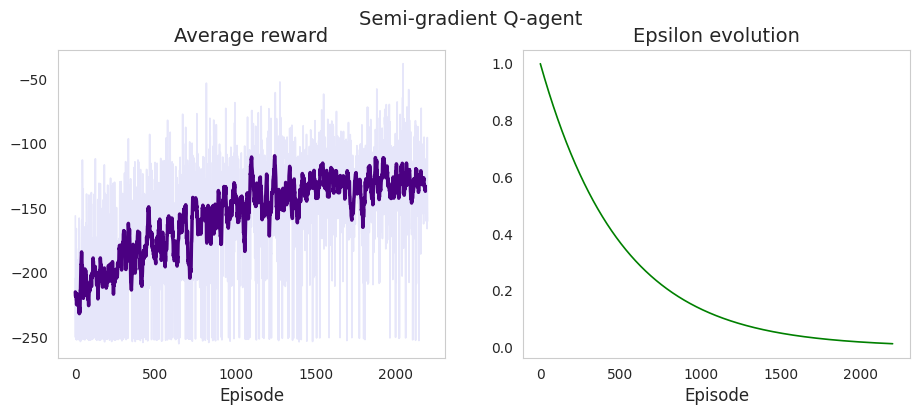

In [ ]:

# Plot reward evolution and exponential decay of epsilon

fig, axs = plt.subplots(1, 2, figsize=(11, 4))

titles = ["Average reward", "Epsilon evolution"]
colors = ["lavender", "g"]

eps, avg_reward = store_Q["epsilon"], store_Q["avg_reward_episode"]

for idx, (ax, score, title) in enumerate(zip(axs, [avg_reward, eps], titles)):
  if idx==0:
    ax.plot(score[:2200], linewidth=1.2, c=colors[idx])
    means = np.lib.stride_tricks.sliding_window_view(score[:2200], 15).mean(1).reshape(-1)
    ax.plot(means, linewidth=2.5, c="indigo")
    ax.grid(False)
  else:
    ax.plot(score[:2200], linewidth=1.2, c=colors[idx])
    ax.grid(False)
  ax.set_xlabel('Episode', fontsize=12)
  ax.set_title(title, fontsize=14)

plt.suptitle("Semi-gradient Q-agent", fontsize=14)

plt.grid(False)

plt.savefig('evolution_Q2_off.jpg', bbox_inches='tight', dpi=300)   
plt.show()
    

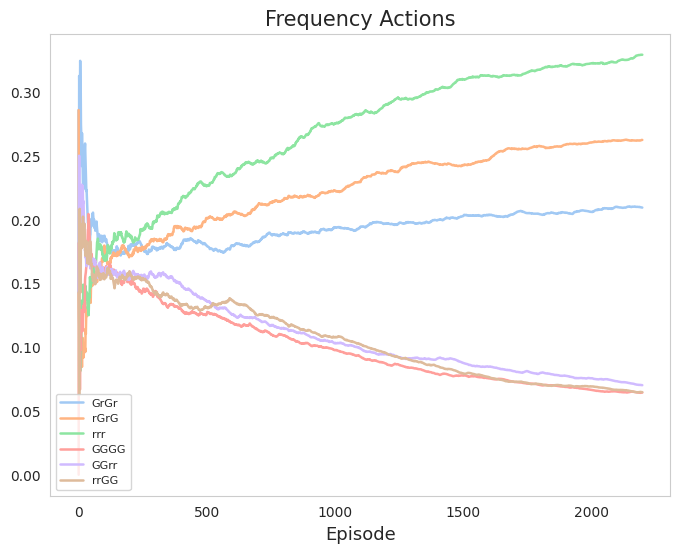

In [ ]:

# Frequency analysis of selected actions throughout episodes

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

title = "Frequency Actions"
label_actions = ["GrGr", "rGrG", "rrr", "GGGG", "GGrr", "rrGG"]

action_freq = np.array(store_Q['action_freq'])
    
for i in range(action_freq.shape[1]):
  ax.plot(action_freq[:2200, i], linewidth=1.8, label=label_actions[i])
ax.legend(fontsize=8, loc="lower left")
ax.set_xlabel('Episode', fontsize=13)
ax.set_title(title, fontsize=15)
ax.grid(False)

plt.savefig('action_freq_Q_off.jpg', bbox_inches='tight', dpi=300)   
plt.show()
    

In [ ]:

def get_value(agent, state):
  """ Function used to plot the estimates of state-action value """
  active_tiles = agent.tc.get_tiles(*state) 
  action, value = agent.choose_action(active_tiles, greedy=True)
  return action, value



def create_grids(agent, env):
    """ Create value and policy grid given an agent. It does it for both of the agents
        depending on the string passed as "algo". Converts estimated state-action values 
        to state values and builds a policy dictionary that maps observations to actions"""
        
    range_ns = list(range(env.observation_space["NS"].start, env.observation_space["NS"].start + env.observation_space["NS"].n -1))
    range_we = list(range(env.observation_space["WE"].start, env.observation_space["WE"].start + env.observation_space["WE"].n -1))

    x_distances, y_distances, wait_times, pas = np.meshgrid(range_ns, range_we, 100, 1)
    
    # # create the value grid for plotting
    grid_values = np.apply_along_axis(
        lambda obs: get_value(agent, obs)[1],
        axis=2,
        arr=np.dstack([x_distances, y_distances, wait_times, pas])
        )
    
    grid_policy = np.apply_along_axis(
                    lambda obs: get_value(agent, obs)[0],
                    axis=2,
                    arr=np.dstack([x_distances, y_distances, wait_times, pas])
                    )

    value_grid = x_distances, y_distances, grid_values
    policy_grid = x_distances, y_distances, grid_policy

    return value_grid, policy_grid


def plot_best_policy(env, grid_policy, filename="optimal_policy_final"):
    """ Function to plot optimal policy, that is the action that maximizes the
        estimated state-action value for each state. The results are visualized
        as a 2-dimensional heatmap  """
    fig, ax = plt.subplots(1, 1, figsize=(22, 12))

    ax = sns.heatmap(grid_policy[:, ::-1, 0], linewidth=0, annot=True, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), cbar=False)

    ax.set_title(f"Optimal policy", fontsize=20)

    ax.set_xlabel("Length of NS queue", fontsize=14)
    ax.set_ylabel("Length of WE queue", fontsize=14)


    range_ns = list(range(env.observation_space["NS"].start, env.observation_space["NS"].start + env.observation_space["NS"].n-1))
    range_we = list(range(env.observation_space["WE"].start, env.observation_space["WE"].start + env.observation_space["WE"].n-1))
        
    # plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=300) 

    plt.show()



In [ ]:

# Create basis for 3-dimensional plotting of estimated state values
# together with agent's optimal policy 

value_grid, policy_grid = create_grids(agent_Q, env)

x_distances, y_distances, grid_values = value_grid
x_distances, y_distances, grid_policy = policy_grid


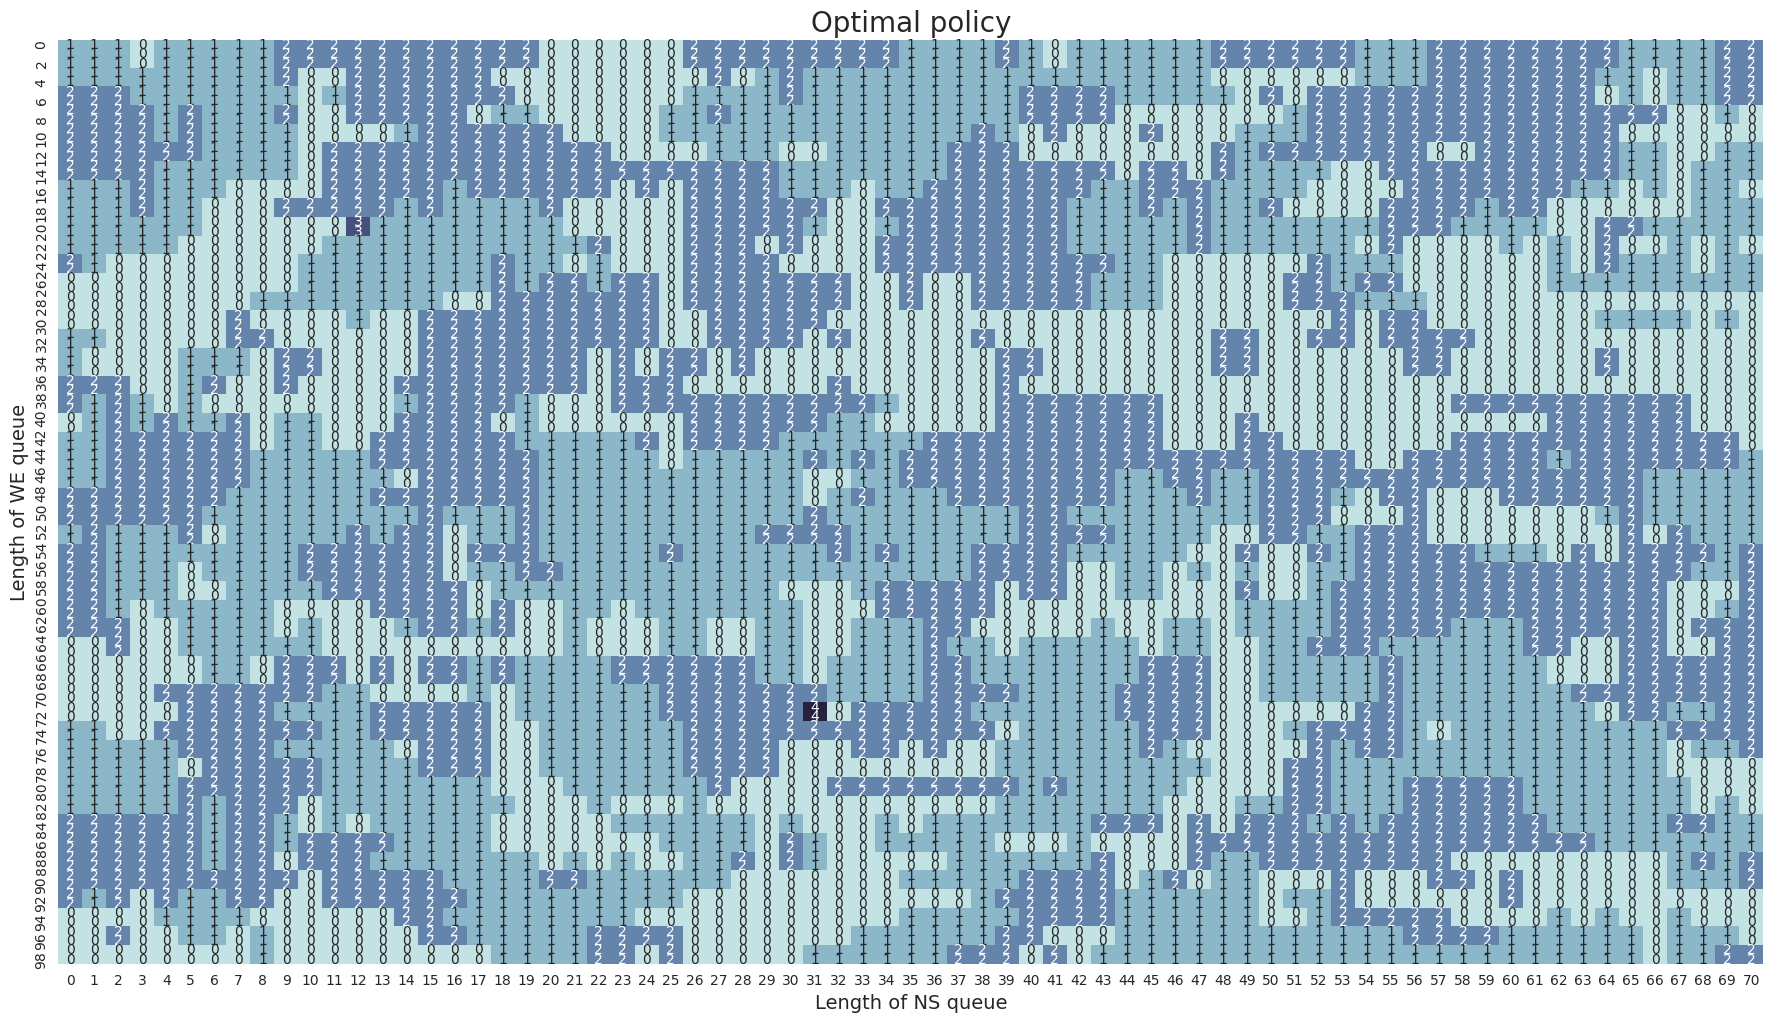

In [ ]:

# Plot of trained agent's optimal policy

plot_best_policy(env, grid_policy, filename="optimal_policy_tiles")


## DQN agent

In [ ]:


# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [ ]:

steps_done = 0


def select_action(env, state, policy_net):
    global steps_done, EPS_START, EPS_END, EPS_DECAY
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1), eps_threshold
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), eps_threshold


def plot_scores(episode_scores, show_result=False):
    plt.figure(1)
    scores_t = torch.tensor(episode_scores, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(scores_t.numpy())

    if len(episode_scores) >= 100:
        means = scores_t.unfold(0, 40, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(39), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())
            

In [ ]:

def optimize_model(memory, policy_net, target_net, optimizer, criterion):
    global BATCH_SIZE, GAMMA

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not False,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not False])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]  # predicted max next state
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    state_action_values = policy_net(state_batch).gather(1, action_batch)  # predicted q values

    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 80)
    optimizer.step()

    return memory, policy_net, target_net



In [ ]:

# Get number of actions from gym action space
n_actions = env.action_space.n

def loop_dqn(env, memory, agent_info, policy_net, target_net, optimizer, criterion):

    global TAU, n_actions
    num_episodes = agent_info.get("num_episodes", 5000)  # agent initialization with info dictionary

    store, best_score, store_action_count = defaultdict(list), 0, defaultdict(int)
    
    # Loop over episodes
    for i_episode in range(1, num_episodes+1):

      state, info = env.reset()   # first state
      state = torch.tensor(list(state.values()), dtype=torch.float32, device=device).unsqueeze(0)

      runn_score, runn_rewards = 0, []

      while True:
        action, runn_eps = select_action(env, state, policy_net)
        store_action_count[action] += 1

        next_state, rew, done, _, info = env.step(action.item())
        reward = torch.tensor([rew], device=device)
        runn_rewards.append(rew)

        if (done) or (info["score"]>30000):
          next_state = False

        else:
          next_state = torch.tensor(list(next_state.values()), dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if len(memory) > BATCH_SIZE:
          memory, policy_net, target_net = optimize_model(memory, policy_net, target_net, optimizer, criterion)

        # Soft update of the target network's weights
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if (done) or (info["score"]>30000): 
            # update
            best_score = max(best_score, info["score"])
            store["total_max_scores"].append(best_score)
            store["total_scores"].append(info["score"])
            store["epsilon"].append(runn_eps)
            store["avg_reward_episode"].append(np.mean(runn_rewards))
            # plot
            plot_scores(store["total_scores"])
            break
        
      tot_chosen = np.sum(list(store_action_count.values()))
      store["action_freq"].append([store_action_count.get(action, 0)/tot_chosen for action in range(n_actions)])

    plot_scores(store["total_scores"], show_result=True)
    plt.ioff()
    plt.show()
    return policy_net, target_net, store


In [ ]:

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.bn = nn.BatchNorm1d(n_observations)
        self.layer1 = nn.Linear(n_observations, 128) 
        self.layer2 = nn.Linear(128, 128)  
        self.layer3 = nn.Linear(128, n_actions) 

    def forward(self, x):
        x = F.leaky_relu(self.layer1(x), negative_slope=0.05)  
        x = F.leaky_relu(self.layer2(x), negative_slope=0.05)
        return self.layer3(x)
        
        

In [ ]:
# Environment initialization (no render for training)


env_steps = 150
max_waiting_time = 25
ps_ns = np.random.uniform(low=0.025, high=0.035, size=1)
ps_ew = np.random.uniform(low=0.06, high=0.065, size=1)
ps = np.tile(np.concatenate((ps_ns, ps_ew)), 2)

env_info = {"ps": ps, "max_wait_time": max_waiting_time, "env_steps": env_steps, "n_states": 2}        
        
env = gym.make("traffic_control-v0", env_info=env_info) 



In [ ]:

BATCH_SIZE = 128    #number of transitions sampled from the replay buffer
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 1e-4    # 0.05
EPS_DECAY = 800
TAU = 0.005  # update rate of the target network
LR = 1e-4
n_episodes = 250


# Get number of actions from gym action space
n_actions = env.action_space.n

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)   
target_net = DQN(n_observations, n_actions).to(device)  
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
criterion = nn.SmoothL1Loss()  # Huber loss
memory = ReplayMemory(2000) 

agent_info = {"num_episodes": n_episodes}



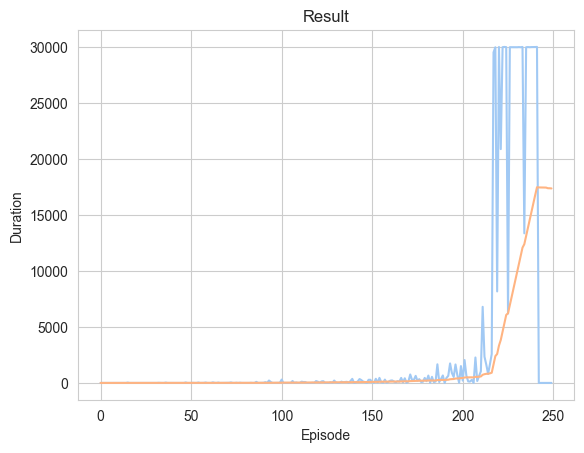

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:

policy_net, target_net, store_Q = loop_dqn(env, memory, agent_info, policy_net, target_net, optimizer, criterion)


In [ ]:

# Save dictionary with results
save_json(store_Q, "store_to_plot")

# Save and Reload models

policy_net, target_net = policy_net.cpu(), target_net.cpu()

torch.save(policy_net.state_dict(), "policy_net_dict")
torch.save(target_net.state_dict(), "target_net_dict")


policy_net2 = DQN(n_observations, n_actions).to(device)   
target_net2 = DQN(n_observations, n_actions).to(device)   

policy_net2.load_state_dict(torch.load("policy_net_dict"))
target_net2.load_state_dict(torch.load("target_net_dict"))

policy_net2.eval()
target_net2.eval()


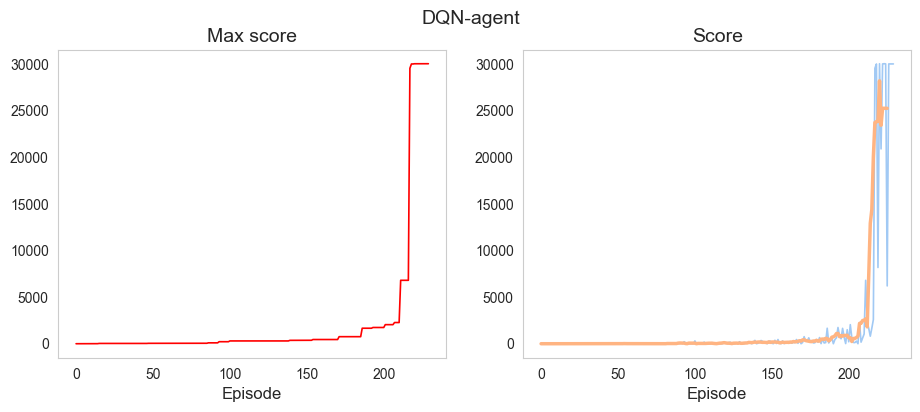

In [ ]:

# plot evolution scores (running mean), together with maximum score

fig, axs = plt.subplots(1, 2, figsize=(11, 4))

titles = ["Max score", "Score"]
colors = ["r", "b"]

total_scores, total_max_scores = store_Q["total_max_scores"], store_Q["total_scores"]

for idx, (ax, score, title) in enumerate(zip(axs, [total_scores, total_max_scores], titles)):
  if idx==1:
    ax.plot(score[:230], linewidth=1.2)
    means = np.lib.stride_tricks.sliding_window_view(score[:230], 5).mean(1).reshape(-1)
    ax.plot(means, linewidth=2.5)
    ax.grid(False)
  else:
    ax.plot(score[:230], linewidth=1.2, c=colors[idx])
    ax.grid(False)
  ax.set_xlabel('Episode', fontsize=12)
  ax.set_title(title, fontsize=14)

plt.suptitle("DQN-agent", fontsize=14)

plt.grid(False)

plt.savefig('evolution_DQN_off.jpg', bbox_inches='tight', dpi=300)   
plt.show()
    

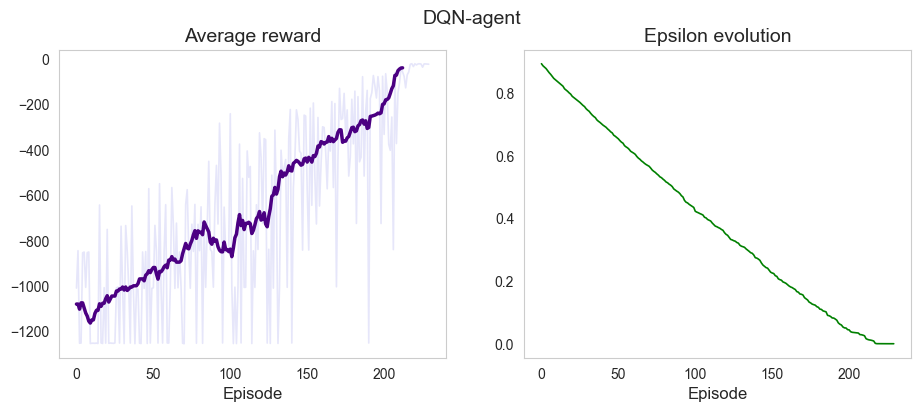

In [ ]:

# plot evolution scores (running mean), together with maximum score

fig, axs = plt.subplots(1, 2, figsize=(11, 4))

titles = ["Average reward", "Epsilon evolution"]
colors = ["lavender", "g"]

eps, avg_reward = store_Q["epsilon"], store_Q["avg_reward_episode"]

for idx, (ax, score, title) in enumerate(zip(axs, [avg_reward, eps], titles)):
  if idx==0:
    ax.plot(score[:230], linewidth=1.2, c=colors[idx])
    means = np.lib.stride_tricks.sliding_window_view(score[:230], 18).mean(1).reshape(-1)
    ax.plot(means, linewidth=2.5, c="indigo")
    ax.grid(False)
  else:
    ax.plot(score[:230], linewidth=1.2, c=colors[idx])
    ax.grid(False)
  ax.set_xlabel('Episode', fontsize=12)
  ax.set_title(title, fontsize=14)

plt.suptitle("DQN-agent", fontsize=14)

plt.grid(False)

plt.savefig('evolution_DQN_off2.jpg', bbox_inches='tight', dpi=300)   
plt.show()
    

In [ ]:

policy_net = policy_net.cpu()


def get_value(state, policy_net):
  """ Function used to plot the estimates of state-action value """

  state = torch.tensor(state, dtype=torch.float32, device="cpu").unsqueeze(0)
  global steps_done, EPS_START, EPS_END, EPS_DECAY
  policy_net.eval()
  with torch.no_grad():
    output = policy_net(state).detach()
    action, value = output.max(1)[1].view(-1).numpy(), output.max(1)[0].view(-1).numpy()
  return action, value


def create_grids(policy_net, env):
    """ Create value and policy grid given an agent. It does it for both of the agents
        depending on the string passed as "algo". Converts estimated state-action values 
        to state values and builds a policy dictionary that maps observations to actions"""

        
    range_ns = list(range(env.observation_space["NS"].start, env.observation_space["NS"].start + env.observation_space["NS"].n-1))
    range_we = list(range(env.observation_space["WE"].start, env.observation_space["WE"].start + env.observation_space["WE"].n-1))

    x_distances, y_distances, wait_times, pas = np.meshgrid(range_ns, range_we, 80, 3)

    # # create the value grid for plotting
    grid_values = np.apply_along_axis(
        lambda obs: get_value(obs,
                    policy_net)[1],
        axis=2,
        arr=np.dstack([x_distances, y_distances, wait_times, pas])
        )
    
    grid_policy = np.apply_along_axis(
                    lambda obs: get_value(obs,
                    policy_net)[0],
                  axis=2,
                  arr=np.dstack([x_distances, y_distances, wait_times, pas])
                    )

    value_grid = x_distances, y_distances, grid_values
    policy_grid = x_distances, y_distances, grid_policy

    return value_grid, policy_grid


In [ ]:

# Create basis for 3-dimensional plotting of estimated state values
# together with agent's optimal policy 

value_grid, policy_grid = create_grids(policy_net, env)

x_distances, y_distances, grid_values = value_grid
x_distances, y_distances, grid_policy = policy_grid


In [ ]:


def plot_state_values(x_distances, y_distances, grid_values, filename):
    '''  Plot State Values, using the variables generated by the create_grids method defined above
         These are 3d images visualizing the maximum estimated state-action value, considering both of the
         available actions  '''

    fig = plt.figure(figsize=(13, 16))  
    fig.set_tight_layout(True)
    
    ax = fig.add_subplot(1, 2, 1, projection="3d")

    surf = ax.plot_surface(
                    x_distances[:,:,0,0],
                    y_distances[:,:,0,0],
                    grid_values[:,:,0, 0],
                    rstride=1,  cstride=1,
                    cmap=cm.coolwarm,
                    edgecolor="none"
                )  

    ax.set_xlabel("Length of NS queue", fontsize=12)  
    ax.set_ylabel("Length of WE queue", fontsize=12) 
    ax.set_zlabel("", fontsize=12, rotation=90) 
    ax.set_zticklabels([])

    ax.view_init(85, 205)  #45, 195


    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    ax.grid(False)


    ax = fig.add_subplot(1, 2, 2, projection="3d")
    
    surf = ax.plot_surface(
                    x_distances[:,:,0,0],
                    y_distances[:,:,0,0],
                    grid_values[:,:,0, 0],
                    rstride=1,  cstride=1,
                    cmap=cm.coolwarm,
                    edgecolor="none"
                )  

    ax.set_xlabel("Length of NS queue", fontsize=12)  
    ax.set_ylabel("Length of WE queue", fontsize=12)
    ax.set_zlabel("State Value", fontsize=12, rotation=90) 

    ax.view_init(45, 205)  

    # First remove fill
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    ax.grid(False)


    plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=300) 

    plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_24588\2833645023.py:70: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=300)


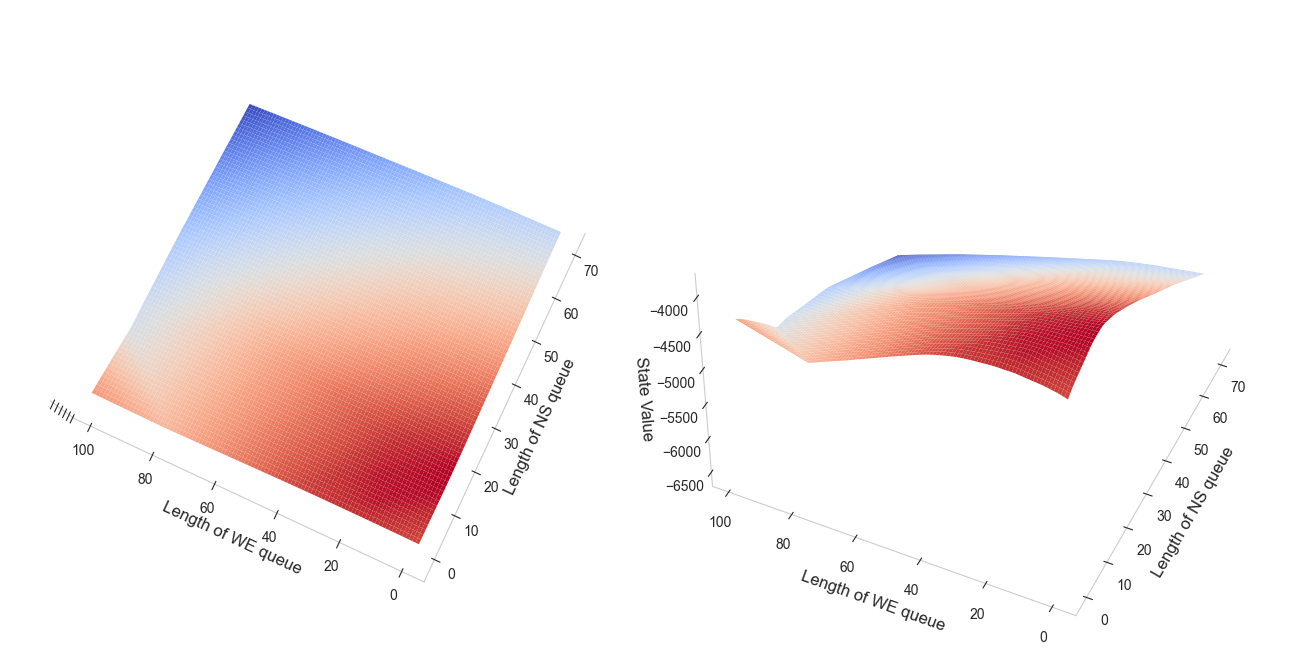

In [ ]:

# Plot of estimated state values

plot_state_values(x_distances, y_distances, grid_values, filename="state_values_DQN")
